# Neoclassical growth model

This is a simple version of the standard neoclassical growth model. The household optimizes his livetime utility:

$$\sum_{t=0}^{\infty} \beta^t u(c_t) \\
\textrm{s.t. } \quad k_{t+1} = (1-\delta) k_t + i_t \\
y_t = k_t^{\alpha} \\
y_t = c_t + i_t$$

which simplifies to the restriction

$$k_t^{\alpha} = c_t + k_{t+1} - (1-\delta)k_t$$

We assume that the functional form on utiltiy is CRRA $u(c) = \frac{c^{1-\frac{1}{\gamma}}}{1-\frac{1}{\gamma}}$. Writing the problem recursively, we then need to solve the dynamic problem:

$$V(k_t) = \max_{c_t} \frac{c_t^{1-\frac{1}{\gamma}}}{1-\frac{1}{\gamma}} + \beta V(k_{t+1}) \\
\textrm{s.t. } \quad k_t^{\alpha} = c_t + k_{t+1} - (1-\delta)k_t$$

The first order condition of this problem results into the Euler equation:

$$c_t = [\beta((1-\delta)+\alpha k_{t+1}^{\alpha-1})]^{-\gamma}c_{t+1}$$

Substituting the budget constraint back into the equation:

$$k_t^{\alpha} - k_{t+1} + (1-\delta)k_t - [\beta((1-\delta)+\alpha k_{t+1}^{\alpha-1})]^{-\gamma} c(k_{t+1}) = 0$$

Using interpolation, we can solve the last equation for each level of $k_{t+1}$.

In [1]:
import numpy as np
import scipy.interpolate as interp
import scipy.optimize as opt
import time
import sys
import matplotlib.pyplot as plt
from numba import jit
from numba import njit

In [2]:
# Setting up the values for the model
parameters = np.zeros(5)
parameters[0] = 0.4         # Alpha
parameters[1] = 0.99        # Beta
parameters[2] = 0.5         # Gamma
parameters[3] = 0.019       # Delta

# Printing the kss for setting up the grids sensible
kss = (parameters[0]*parameters[1]/(1-parameters[1]*(1-parameters[3])))**(1/(1-parameters[0]))
print("The steady state value for capital is %F." % kss)

# Setting up the values for the grid
kmin = 5
kmax = 105
knum = 500

if kss > kmax or kss < kmin:
    sys.exit("The grid must contain the steady state. Adapt kmax and kmin accordingly.")
elif kmax < 1.2*kss:
    sys.exit("The grid must contain the 1.2 times the steady state. Adapt kmax accordingly.")
    

# Setting up the time periods for the simulation of the trajectory
T = 360

The steady state value for capital is 78.871460.


In [3]:
# Create a grid for capital

def initialize(start, end, n, guess = 0):
    """Function initializing the capital grid and an initial guess for the value function
    
    Inputs:
    start         = start value for the capital grid
    end           = end point for the capital grid
    n             = number of grid points for the grid
    guess         = Initial guess for the value function
    
    
    Outputs:
    capital       = discretized capital grid
    value         = initial guess for the value function"""
    
    
    capital = np.linspace(start, end, n)
    value = np.ones((n,))*guess
    
    return capital, value


# Testing areas
capital, value = initialize(kmin, kmax, knum)

The policy function iterates on the Euler equation and makes it zero:

$$k_t^{\alpha} - k_{t+1} + (1-\delta)k_t - [\beta((1-\delta)+\alpha k_{t+1}^{\alpha-1})]^{-\gamma} c(k_{t+1}) = 0$$

In [4]:
# Initial guess for the policy function
guess = np.zeros(np.shape(capital))
guess = guess + kss**parameters[0] - parameters[3]*kss # Guessing the initial level to be the steady state level

def euler(cap, guess, capital, parameters):
    """Function giving back the exact value for future capital which solves the first order condition
    
    Inputs:
    
    cap     =      value for capital for which the euler equation is evaluated
    guess   =      guess for the policy function in form of a numpy array
    capital =      matrix for capital, used in the interpolation
    
    
    Output:
    
    loc     =      value for future capital which solves the euler equation
    
    """
    
    alpha = parameters[0]
    beta = parameters[1]
    gamma = parameters[2]
    delta = parameters[3]
    kss = (alpha*beta/(1-beta*(1-delta)))**(1/(1-alpha))
    
    # Interpolating over the policy function
    tck = interp.splrep(capital, guess)
    y_app_spl = lambda x: interp.splev(x, tck)
    
    # Evaluating the residual as a function of future capital
    res = lambda cap1: cap**alpha - cap1 + (1-delta)*cap - (beta*((1-delta)+alpha*cap1**(alpha-1)))**(-gamma)*y_app_spl(cap1)
    loc = opt.fsolve(res, kss)        # We use kss here, since this makes the optimization stable
    return loc


# Testing area
alpha = parameters[0]
beta = parameters[1]
gamma = parameters[2]
delta = parameters[3]

kss = (alpha*beta/(1-beta*(1-delta)))**(1/(1-alpha))

# Extracting the optimal future capital
test1 = euler(kss, guess, capital, parameters)
print("\nThe solution of the euler equation is %f " % test1)

# Interpolating over the capital grid to be able to continuously plug in the values for capital
tck = interp.splrep(capital, guess)
y_app_spl = lambda x: interp.splev(x, tck)

# Printing the residual of the euler equation
print("\nThe residual of the euler equation is %.10f" % (kss**alpha - test1 + (1-delta)*kss - (beta*((1-delta)+alpha*test1**(alpha-1)))**(-gamma)*y_app_spl(test1)))


The solution of the euler equation is 78.871460 

The residual of the euler equation is -0.0000000000


#### Actual policy function iteration

In [5]:
# Policy function iteration
def pfi(capital, guess, parameters):
    """Define the function"""
    
    start = time.time()
    new = np.copy(capital)
    iteration = 0
    error = 1
    while error > 10**(-6):
        iteration += 1
    
        # Until convergence, generate a new policy function based on the current capital stock and the euler solution
        for index, k in enumerate(capital):
            # Generate a new policy function
            new[index] = k**parameters[0] - euler(k, guess, capital, parameters) + (1-parameters[3])*k
    
        # Calculating the error
        error = np.max((new - guess)/guess)
    
        # Updating the policy function which is employed in the next iteration round
        guess = np.copy(new)
    
    end = time.time()

    print("\nPolicy function iteration took %1.F iterations, and took %f seconds." % (iteration, end - start))
    return guess

# Testing area
guess = pfi(capital, guess, parameters)


Policy function iteration took 227 iterations, and took 61.930089 seconds.


Let's extract the policy function for capital.

In [6]:
# Guess is the policy function for consumption, now we need to extract the policy function for capital
policy = capital**alpha - guess + (1-delta)*capital

# Printing the policy function for consumption
print(policy[-10:])

[102.76801494 102.96476595 103.16151529 103.35826296 103.55500897
 103.75175332 103.94849603 104.14523709 104.34197651 104.53871429]


Having the policy function, we now can plot it.

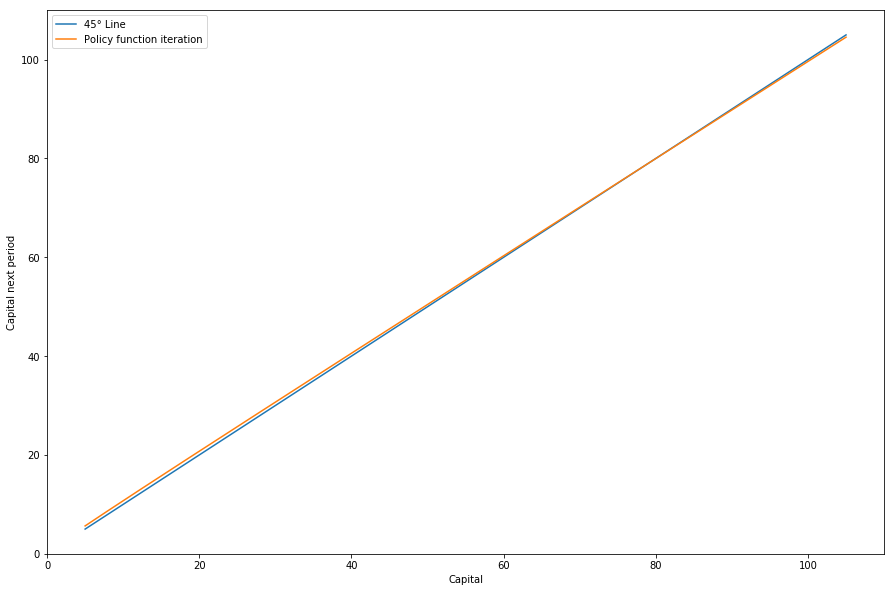

In [7]:
# Plotting the VFI, exact solution, and the policy function iteration solution
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(capital, capital, label = "45° Line")
ax.plot(capital, policy, label = "Policy function iteration")
ax.set_xlabel("Capital")
ax.set_ylabel("Capital next period")
ax.legend(loc = 2)
plt.show()

Next let's find the steady state. We do this by finding the root of an excess function:

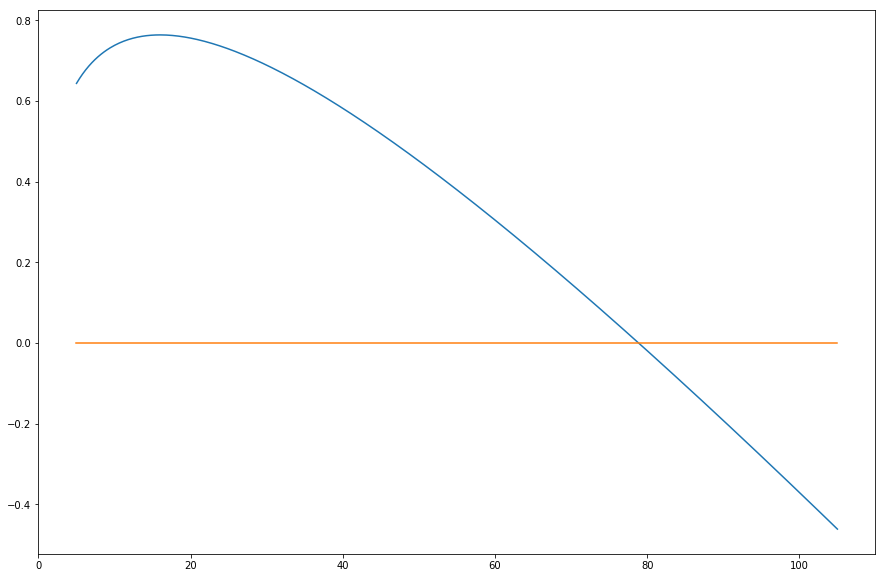

In [8]:
# To check, whether both generate the same steady state we find the root of the excess function:
def excess(pol, cap):
    ex = pol - cap
    return ex

# Generate the excess function
excess = excess(policy,capital)

# Plot the excess function
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(capital, excess, label = "Excess function")
ax.plot(capital, np.zeros(knum,))
plt.show()

In [9]:
# Let's find the root
tck = interp.splrep(capital, excess)
conexcess = lambda x: interp.splev(x, tck)

# Find the root
loc = opt.fsolve(conexcess, kss)
print("The numerical steady state of the model is %F, while the true steady state is %F" % (loc, kss))

The numerical steady state of the model is 78.871460, while the true steady state is 78.871460


Since we are rather satistfied with the precision, we now can simulate the economy.

In [10]:
# Defining a function to simulate different trajectories
def simulate(k0, T, policy, guess):
    """Description of the function"""
    
    # Discretizing the policy for capital functions to be continuous
    tck = interp.splrep(capital, policy)
    polcap = lambda x: interp.splev(x, tck)

    
    # Discretizing the policy for capital functions to be continuous
    tck = interp.splrep(capital, guess)
    polcon = lambda x: interp.splev(x, tck)

    
    # Setting up the arrays holding the time series of the simulated economy
    consumption = np.zeros(T)
    investment = np.zeros(T)
    output = np.zeros(T)
    capital1 = np.zeros(T+1)
    capital1[0] = k0

    for t in np.arange(0,T):
        consumption[t] = polcon(capital1[t])
        output[t] = capital1[t]**alpha
        investment[t] = output[t] - consumption[t]
        capital1[t+1] = investment[t] + (1-delta)*capital1[t]
    
    return consumption, investment, output, capital1

# Simulating the time series behavior
con1, inv1, out1, cap1 = simulate(0.1*kss, T, policy, guess)
con2, inv2, out2, cap2 = simulate(1.2*kss, T, policy, guess)

Using the simulated behavior, we now can plot the development of different economies with different initial states.

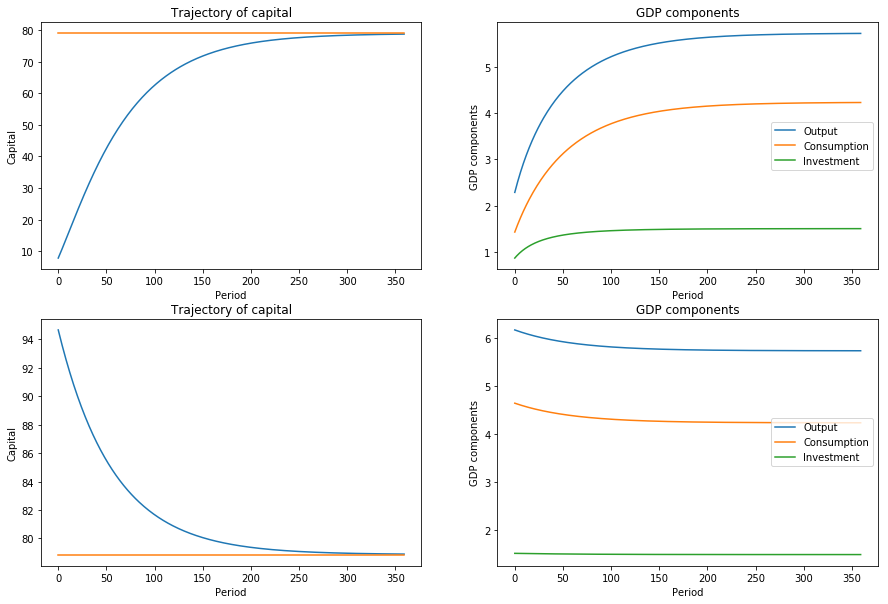

In [11]:
# Defining a time sequence and a vector with the kss
time = np.arange(0,T)
vkss = np.zeros(T)
vkss[:] = kss

# Plot the excess function
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(15,10))
axes[0,0].plot(time, cap1[0:T])
axes[0,0].plot(time, vkss, label = "Steady-State")
axes[0,0].set_title("Trajectory of capital")
axes[0,0].set_xlabel("Period")
axes[0,0].set_ylabel("Capital")

axes[0,1].plot(time, out1, label = "Output")
axes[0,1].plot(time, con1, label = "Consumption")
axes[0,1].plot(time, inv1, label = "Investment")
axes[0,1].set_title("GDP components")
axes[0,1].set_xlabel("Period")
axes[0,1].set_ylabel("GDP components")
axes[0,1].legend(loc=5)

axes[1,0].plot(time, cap2[0:T])
axes[1,0].set_title("Trajectory of capital")
axes[1,0].plot(time, vkss, label = "Steady-State")
axes[1,0].set_xlabel("Period")
axes[1,0].set_ylabel("Capital")

axes[1,1].plot(time, out2, label = "Output")
axes[1,1].plot(time, con2, label = "Consumption")
axes[1,1].plot(time, inv2, label = "Investment")
axes[1,1].set_title("GDP components")
axes[1,1].set_xlabel("Period")
axes[1,1].set_ylabel("GDP components")
axes[1,1].legend(loc=5)

plt.show()

Let's plot the phase diagram, showing the saddle path for the economy to transit to the steady state. The phase diagram shows the convergence path of the economy, and the function of values for which consumption and capital are constant. Consumption is constant, when capital is at it's steady state value. However, capital is constant, if the difference in capital between periods, is zero.

$$k_{t+1} = (1-\delta)k_t + i_t \\
k_{t+1} - k_t = i_t - \delta k_t \\
0 = i_t - \delta k_t \\
i_t = \delta k_t \\
y_t - c_t = \delta k_t \\
c_t = y_t - \delta k_t$$

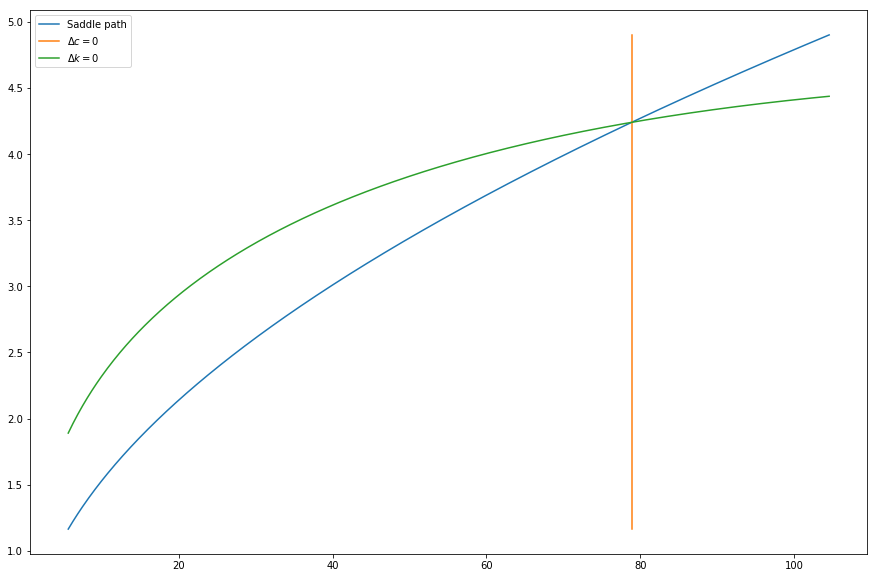

In [12]:
# Setting up some arrays
vkss = np.zeros(knum)
vkss[:] = kss              # Array for the value where consumption is constant
css = policy**alpha - delta*policy

# Plotting the phase diagram
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(policy, guess, label = "Saddle path")
ax.plot(vkss, guess, label = r"$\Delta c = 0$")
ax.plot(policy, css, label = r"$\Delta k = 0$")
ax.legend(loc=2)
plt.show()

The graph looks a bit different from what we know from the books. This is since the books as well portray the situation, where we have a capital stock so high, that all output is going into investment. To achieve this, we need to have:

$$c_t = 0 \\
y_t = \delta k_t \\
k_t^{\alpha} = \delta k_t \\
k_t^{\alpha} - \delta k_t = 0$$

Let's find how big $k_t$ needs to be for this to happen. We know that one solution to this equation would be $k_t = 0$, but we actually exclude this equilibrium, since in such an equilibrium there would not be production. Therefore, we can divide by $k_t$:

$$k_t^{\alpha-1} = \delta \\
k_t = \delta^{\frac{1}{\alpha-1}}$$

In [13]:
# As derived from theory
loc1 = delta**(1/(alpha-1))

# Define the function
concave = lambda k: k**alpha - delta*k
loc2 = opt.fsolve(concave, 700)
print("The numerical value is %F, while the theoretical value is %F." % (loc1, loc2))

The numerical value is 739.169432, while the theoretical value is 739.169432.


Since this number is very high, we do not continue here to show the whole phase diagram.

### Euler equation residual

THe euler equation residual is a way to compute the error we have in our approximation with the policy function.

$$EER(k) = S(k_t) - [\beta((1-\delta)+\alpha(k_{t+1})^{\alpha-1})]^{-\gamma}S(k_{t+1}) \\
\textrm{with } k_{t+1} = (1-\delta)k_t + k_t^\alpha - S(k_t)$$

Where $S(k_t)$ is the continuous policy function.

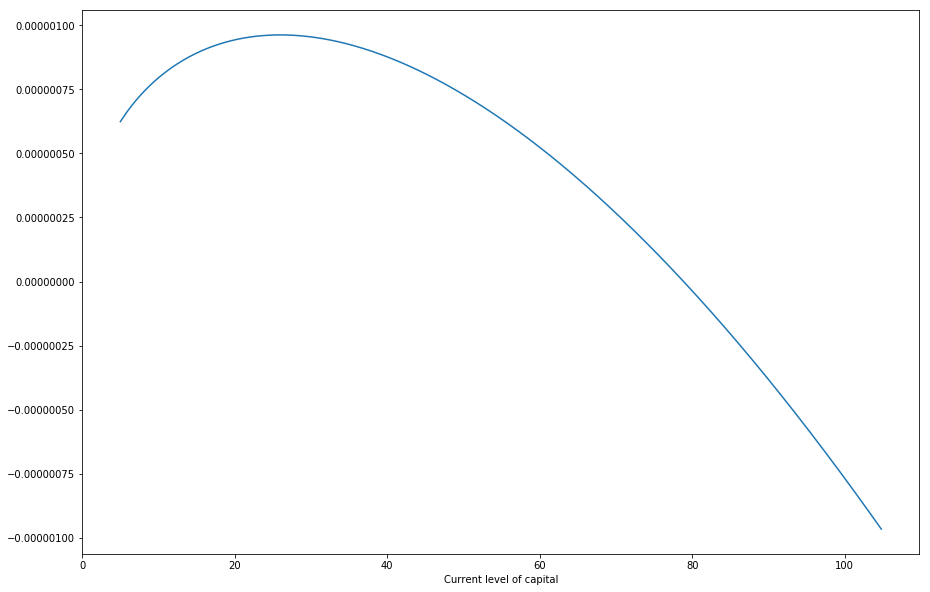

In [14]:
# Interpolating the policy function
tck = interp.splrep(capital, guess)
pol = lambda x: interp.splev(x, tck)

# Using the interpolated policy function to compute the EER
EER = lambda k: pol(k)-((beta*((1-delta)+alpha*((1-delta)*k+k**alpha-pol(k))**(alpha-1)))**(-gamma))*pol((1-delta)*k+k**alpha-pol(k))
EEE = lambda k: (EER(k)/pol(k))

# Setting up the spacing of the grid for which we want to analyze the euler equation error (EEE)
m = (kmax-kmin)/knum

# Setting up the capital grid and calculating the error
k = np.arange(kmin,kmax,m)
error = np.zeros(knum)
for index, cap in enumerate(k):
    error[index] = EEE(cap)

# Plotting the EEE
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(k, error, label = "Euler equation error")
ax.set_xlabel("Current level of capital")
plt.show()

The euler equation error is actually defined as:

$$\max_k |\frac{EER(k)}{S(k)}|$$

It's economic interpretation is as follows: If an agent makes a decision on the allocation of 1000€, using the approximated decision rules, he would make an error of $1000*\max_k |\frac{EER(k)}{S(k)}|$€.

In [15]:
print("The euler equation error is %F" % np.amax(np.abs(error)))
print("\nThis results in an error for the agent of %F €" % np.amax(np.abs(1000*error)))

The euler equation error is 0.000001

This results in an error for the agent of 0.000966 €


As a result, the EEE is really small. This showes that our approximation is rather good.